![banner.png](attachment:banner.png)

# Aplicaciones de Redes Convolucionales - Semana 6
## _Transfer Learning_ para nuevas tareas usando redes pre-entrenadas en Keras
### Laboratorio Sumativo

### Propósito de la actividad
En esta actividad mostraremos cómo usar redes convolucionales para visión computacional que ya han sido pre-entrenadas con grandes cantidades de datos, pero que quieren ser usadas con unos nuevos datos y para una tarea diferente.

Esto corresponde a la aplicación de _transfer learning_, en donde se remueven las últimas capas de una red pre-entrenada, y después de ponen nuevas capas entrenables adicionales. En _Keras_ este proceso también se conoce como _fine tunning_.

Otra opción, que es muy parecida al _transfer learning_ es usar capas intermedias de una red pre-entrenada y calcular las variables transformadas hasta esta capa. Estas variables, se pueden convertir en una nueva muestra de entrenamiento para un modelo de _machine learning_. En _Keras_ este proceso se conoce como _feature extraction_.


### Instrucciones generales

El laboratorio contiene dos partes, la primera (A) consiste en la explicación de _transfer learning_ usando la red VGG16, y la segunda (B) corresponde a la asignación del laboratorio sumativo.

Para la segunda parte, debe realizar la entrega correspondiente con la solución.

### Librerías a importar

A continuación se muestran los comandos a ejecutar para poder implementar los procedimientos de este notebook:

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [2]:
import numpy as np
import matplotlib.pyplot as plt
#Las siguientes dos líneas evitan la generación de "warnings" y "flags" al importar keras y tensorflow.
#Dichas advertencias no comprometen el funcionamiento del código.
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#Importación de keras y tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

### A. Uso de _CNN_ pre-entrenada para Aprendizaje por Transferencia

La estructura de modelo secuencial tipo CNN puede ser importada directamente sin necesidad de definir cada una de las capas, como conv2D, MaxPooling, etc. Muchas redes pueden ser implementadas automáticamente desde _Keras_ (https://keras.io/api/applications/). Sin embargo, muchas veces estas redes son bastante genéricas. Por ejemplo, muchas de ellas han sido entrenadas con los datos de _IMAGENET_ para clasificación multiclase, pero con alrededor de 1000 clases diferentes. Cuando requerimos un uso más específico, por ejemplo, reconocer la marca de un vehículo o el tipo de ambiente en una fotografía, este tipo de clasificación genérica no nos funciona muy bien.

La opción más directa, es hacer nuestra propia red convolucional desde cero con nuestros propios datos. Para esto, podemos tomas como inspiración muchas de las arquitecturas que ya han sido probadas (AlexNet, VGG16, GoogleNEt, ResNet, etc.). Sin embargo, es posible que, dado que nuestros datos corresponden a una aplicación más especializada, no tengamos a nuestra disposición la cantidad suficiente de imágenes para entrenar nuestra red.

Otra opción más útil, sería usar como base de nuestro modelo, una red ya pre-entrenada. Por ejemplo, las primeras capas de una red tipo ResNet. El principio de este enfoque, es que las primeras capas todavía no se han especilizado completamente y son bastante genéricas en términos de reconocer patrones básicos que pueden funcionar en diversos problemas. Para estas primeras capas tomamos los pesos (estimación de los parámetros) ya fijos (recordemos que tenemos la opción de definir el parámetro "weights"). Sobre estas capas, podemos adicionar unas nuevas capas (generalmente son del tipo completamente conectadas) y entrenar los pesos de estas con los datos que tenemos a disposición para nuestro problema.

Dentro de la calibración de los modelos de _Transfer Learning_, aparecen entonces nuevos hiper-parámetros que son necesarios de calibrar, como el número de capas del modelo base ya preentrenado y el número de capas entrenables adicionales. Esto depende, por supuesto, de la cantidad de imágenes que tengamos disponibles y de la complejidad de la tarea.

#### _Transfer Learning_ en Keras usando VGG16

La forma más sencilla de usar _transfer learning_ con redes pre-entrenadas, es cargando la red con los pesos fijos, como por ejemplo en el modelo VGG16, usando  `weights='imagenet'`, que incluye los valores de todos los parámetros ya entrenados con los datos descritos del ILSVRC. Sin embargo, en este caso el parámetro `include_top`, que hace referencia a si se incluyen las últimas 3 capas de tipo completamente conectadas (_fully connected_) se define como `False`, dado que se reemplazarán por capas nuevas.

Además de esto, es necesario añadir las capas nuevas con las cuales crearemos nuestro modelo. Una vez se tiene la configuración del modelo, se fijan los valores de las primeras capas, haciendo para cada una de las _layers_ que no se entrenan `layer.trainable = False`.

Miremos la implementación usando la red VGG16 contenida en _Keras Applications_:

In [3]:
#Importar modelo entrenado VGG16 con las últimas capas
#Puede tomar algunos segundos
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Sobre este modelo, el primer paso (que es opcional), es usar una operación de _pooling_ global sobre la salida de la última capa ("block5_pool"), para pasar a una arreglo en una dimensión de tamaño [1,1,512].

In [4]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
base=GlobalAveragePooling2D()(vgg.output)

Después, se pueden adicionar capas completamente conectadas ("Dense") de diferentes tamaños. En este caso, añadimos una capa de 256 nodos con activación RELU:

In [5]:
new=Dense(128,activation='relu')(base)

De la misma forma, es posible adicionar capas adicionales.

Supongamos que el nuevo problema que queremos resolver es de reconocimiento de imágenes con 5 clases diferentes de objetos. Para esto, es necesario crear la capa de salida:

In [6]:
out_layer=Dense(5,activation='softmax')(new)

El último paso antes de compilar el modelo, es fijar las capas cuyos pesos queremos que se mantengan fijos, mientras que las capas restantes se dejan libres para entrenar. En este caso, todas las capas anteriores del VGG16 a las capas completamente conectadas se dejarán fijas:

In [7]:
for layer in vgg.layers:
    layer.trainable = False

Ahora se puede definir el nuevo modelo que va desde los _inputs_ del modelo base (VGG) hasta la capa de salida definida:

In [8]:
from tensorflow.keras.models import Model
model=Model(inputs=vgg.input,outputs=out_layer)

Y con esto, ya es posible compilar el modelo. En este caso usamos _Adam_ con un problema de clasificación multiclase. Puede ser definido a conveniencia para calibrar el modelo en términos de hiper-parámetros:

In [9]:
from keras.optimizers import Adam
model.compile(optimizer= Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.995), loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

***
#### Problema de reconocimiento de imágenes y datos a usar

En este caso, resolveremos un problema de identificación de especies de flores. Se tienen 5 diferentes especies que salen en los datos: daisy (margarita), dandelion (diente de león), roses (rosas), sunflowers (girasoles), y tulips (tulipanes). La base de datos contiene en total 3670 imágenes en color  y se obtiene directamente de un repositorio usando las herramientas de Tensorflow para carga de datos:

In [10]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

Miremos primero el número total de imágenes:

In [11]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Y algunas imágenes de muestra:

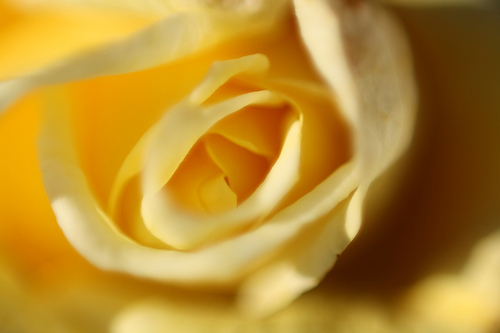

In [12]:
import PIL
import PIL.Image
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

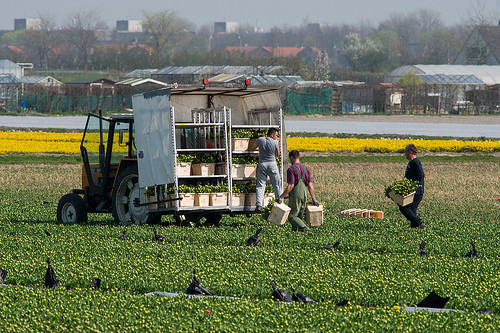

In [13]:
import PIL
import PIL.Image
roses = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(roses[4]))

Ahora definimos los datos para entrenamiento y para validación (`train_ds` y `val_ds` respectivamente) usando un tamaño de 224 por 224, para que sea compatible con VGG16:

In [14]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Revisemos las dimensiones en cada uno de los conjuntos de datos:

In [15]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


Por último, antes de usar los datos, los escalamos para que estén en el rango [0,1], y no tengamos problemas en el entrenamiento:

In [16]:
from tensorflow.keras import layers

scale_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (scale_layer(x), y))
val_ds = val_ds.map(lambda x, y: (scale_layer(x), y))

Con estos elementos ya es posible entrenar el modelo usando "model.fit". _Nota:_ El "warning" referente al uso de funciones `lambda` no representa un problema ni afecta la ejecución del código y será eliminado en próximas versiones de Tensorflow.

A continuación, se entrenará el modelo compilado. Dicho entrenamiento toma alrededor de 3 horas en el kernel de Coursera, por lo que se recomienda ejecutar todo el código de una sola vez en la opción "Cell -> Run All" para evitar que el kernel se cierre por largo tiempo de ejecución.

In [17]:
epochs = 10
model_train = model.fit(train_ds,epochs=epochs,verbose=1,validation_data=val_ds)

Epoch 1/10
92/92 [==============================] - 40s 298ms/step - loss: 0.9003 - accuracy: 0.6621 - val_loss: 0.6233 - val_accuracy: 0.7766
Epoch 2/10
92/92 [==============================] - 15s 161ms/step - loss: 0.5572 - accuracy: 0.8038 - val_loss: 0.6226 - val_accuracy: 0.7725
Epoch 3/10
92/92 [==============================] - 17s 183ms/step - loss: 0.5274 - accuracy: 0.8110 - val_loss: 0.5190 - val_accuracy: 0.7929
Epoch 4/10
92/92 [==============================] - 16s 165ms/step - loss: 0.4269 - accuracy: 0.8498 - val_loss: 0.4908 - val_accuracy: 0.8161
Epoch 5/10
92/92 [==============================] - 17s 173ms/step - loss: 0.4142 - accuracy: 0.8481 - val_loss: 0.5236 - val_accuracy: 0.8120
Epoch 6/10
92/92 [==============================] - 17s 185ms/step - loss: 0.3879 - accuracy: 0.8549 - val_loss: 0.4963 - val_accuracy: 0.8215
Epoch 7/10
92/92 [==============================] - 15s 163ms/step - loss: 0.3404 - accuracy: 0.8801 - val_loss: 0.4525 - val_accuracy: 0.8324

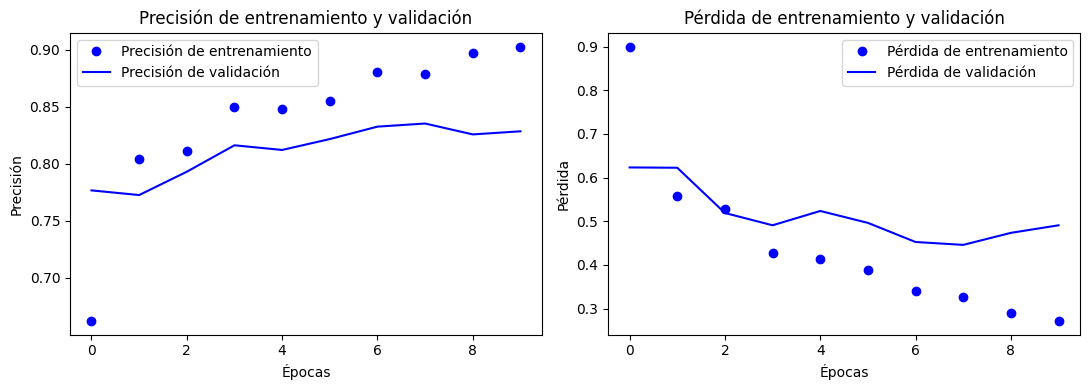

In [18]:
import matplotlib.pyplot as plt
accuracy = model_train.history['accuracy']
val_accuracy = model_train.history['val_accuracy']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))

# Crear una figura con dos subplots (uno para accuracy y otro para loss)
plt.figure(figsize=(11, 4))

# Subplot para accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo', label='Precisión de entrenamiento')
plt.plot(epochs, val_accuracy, 'b', label='Precisión de validación')
plt.title('Precisión de entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Subplot para loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida de validación')
plt.title('Pérdida de entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

***
### B. Laboratorio Sumativo _Transfer Learning_

El laboratorio consiste en hacer _transfer learning_ usando los datos de flores que se cargaron y con la partición que se hizo para entrenamiento y validación. Sin embargo, en lugar de usar la red VGG16, usaremos la red Inception, la cual también está disponible en Keras (https://keras.io/api/applications/inceptionv3/). *Nota:* Tenga en cuenta que, debido a que la implementación de estos algoritmos toma varias horas, es muy probable que el kernel de Coursera se reinicie durante la corrida de alguno de los siguientes puntos. Por lo tanto, se recomienda ejecutar este notebook en un computador local o en Google Colab.


#### 1. Adaptación de la red InceptionV3 para _transfer learning_ [30 puntos]

Acá, debe preparar la red InceptionV3 para _transfer learning_. Para ello, debe remover las capas finales (completamente conectadas) usando la opción `top=False`.

Además, después de usar "global pooling" para linealizar los datos, agregará una capa adicional completamente conectada con el número de nodos que considere adecuado (hiper-parámetro de calibración). Por último, debe agregar la capa de salida para el problema. No olvide que los parámetros anteriores a las últimas capas no son entrenables.

In [19]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

inception = InceptionV3(input_shape=(224,224,3),weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(inception.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

## Procedimiento:

Se cargó la red neuronal InceptionV3, con los pesos para el set de entrenamiento de la competencia Imagenet y no se incluyeron las ultimas capas. Luego se añadieron una capa de Average Pooling, luego una capa densa con función de activación ReLu, finalmente, se añade la capa de clasificación para las 5 categorías.

#### 2. Estimación del modelo propuesto y calibración de gradiente descendiente [20 puntos]
Usando el modelo propuesto, estime los parámetros asociados. No olvide calibrar el modelo con los algoritmos de estimación correspondiente. También puede considerar un capa de _dropout_ antes de la capa de salida.

In [20]:
from keras.layers import Dropout
x = Dropout(0.5)(x)

for layer in inception.layers:
    layer.trainable = False

model_1 = Model(inputs=inception.input, outputs=predictions)
model_1.compile(optimizer= Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.995), loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

epochs = 10

history = model_1.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
92/92 [==============================] - 24s 176ms/step - loss: 1.1512 - accuracy: 0.7146 - val_loss: 0.4487 - val_accuracy: 0.8501
Epoch 2/10
92/92 [==============================] - 10s 101ms/step - loss: 0.4048 - accuracy: 0.8559 - val_loss: 0.4493 - val_accuracy: 0.8365
Epoch 3/10
92/92 [==============================] - 10s 101ms/step - loss: 0.2895 - accuracy: 0.8937 - val_loss: 0.3797 - val_accuracy: 0.8692
Epoch 4/10
92/92 [==============================] - 11s 112ms/step - loss: 0.2038 - accuracy: 0.9315 - val_loss: 0.3587 - val_accuracy: 0.8747
Epoch 5/10
92/92 [==============================] - 11s 111ms/step - loss: 0.1735 - accuracy: 0.9380 - val_loss: 0.4022 - val_accuracy: 0.8760
Epoch 6/10
92/92 [==============================] - 10s 101ms/step - loss: 0.1312 - accuracy: 0.9523 - val_loss: 0.4185 - val_accuracy: 0.8597
Epoch 7/10
92/92 [==============================] - 11s 107ms/step - loss: 0.1119 - accuracy: 0.9591 - val_loss: 0.4444 - val_accuracy: 0.8760

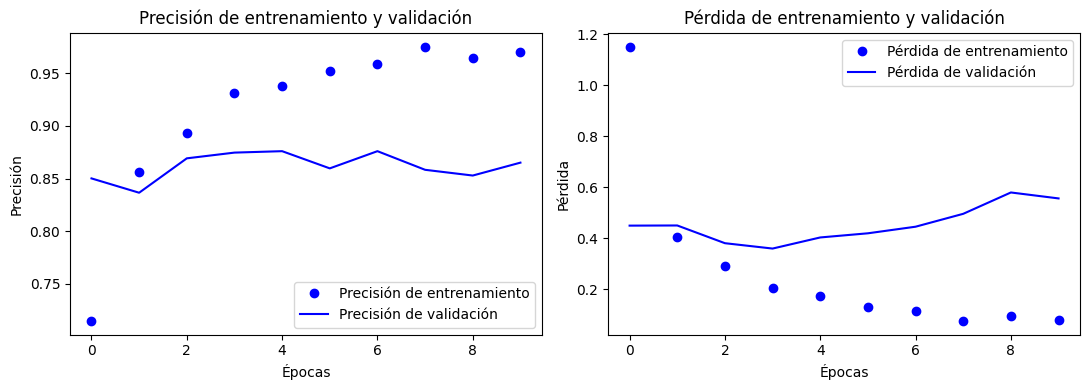

In [21]:
# Opcional: Graficar la precisión y la pérdida durante el entrenamiento

import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.figure(figsize=(11, 4))

# Subplot para accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo', label='Precisión de entrenamiento')
plt.plot(epochs, val_accuracy, 'b', label='Precisión de validación')
plt.title('Precisión de entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Subplot para loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida de validación')
plt.title('Pérdida de entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## Procedimiento y Conclusiones:

Se entrenó el modelo con el mismo optimizador del modelo anterior, para poder hacer una comparación justa, en el cual se usa el optimizador ADAM con los mismo hiperparámetros para 10 epochs.

En el resultado del entrenamiento de la red se observa que para epoch el modelo se ajusta más rápidamente a los datos de entrenamiento, mientras que la precisión en validación varía alrededor del 85%. En cuanto a la perdida se observa el mismo el comportamiento, el set de entrenamiento los valores se ajustan, pero después de la epoch 2 la perdida aumenta en el set de validación.

En conclusión, es un modelo que converge muy rápidamente al problema especifico tratado, lo que da indicios que se tiene sobre ajuste.


#### 3. Comparación con modelos VGG16 sin _transfer learning_ [20 puntos]
Para revisar si hacer _transfer learning_ tiene alguna utilidad en el modelo, ahora deberá estimar todos los parámetros de la red VGG16 (con todos los parámetros estimables), tenga en cuenta que esto puede tardar bastante. Compare los resultados en la muestra de validación.

In [22]:
#Importar modelo entrenado VGG16 con las últimas capas
#Puede tomar algunos segundos

vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
base=GlobalAveragePooling2D()(vgg.output)
new=Dense(128,activation='relu')(base)

out_layer=Dense(5,activation='softmax')(new)

for layer in vgg.layers:
    layer.trainable = True

from tensorflow.keras.models import Model
model=Model(inputs=vgg.input,outputs=out_layer)

from keras.optimizers import Adam
model.compile(optimizer= Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.995), loss='SparseCategoricalCrossentropy', metrics=['accuracy'])



In [23]:
# Definir el número de épocas para el entrenamiento
epochs = 10
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Epoch 1/10
92/92 [==============================] - 66s 516ms/step - loss: 7483849.5000 - accuracy: 0.2098 - val_loss: 1.6157 - val_accuracy: 0.1635
Epoch 2/10
92/92 [==============================] - 38s 408ms/step - loss: 1.6049 - accuracy: 0.2391 - val_loss: 1.6119 - val_accuracy: 0.2398
Epoch 3/10
92/92 [==============================] - 38s 405ms/step - loss: 1.6115 - accuracy: 0.2371 - val_loss: 1.6082 - val_accuracy: 0.2398
Epoch 4/10
92/92 [==============================] - 40s 427ms/step - loss: 1.6057 - accuracy: 0.2388 - val_loss: 1.6074 - val_accuracy: 0.2398
Epoch 5/10
92/92 [==============================] - 40s 428ms/step - loss: 1.6043 - accuracy: 0.2296 - val_loss: 1.6028 - val_accuracy: 0.2398
Epoch 6/10
92/92 [==============================] - 40s 428ms/step - loss: 1.6031 - accuracy: 0.2432 - val_loss: 1.6057 - val_accuracy: 0.2398
Epoch 7/10
92/92 [==============================] - 40s 428ms/step - loss: 1.6030 - accuracy: 0.2377 - val_loss: 1.6047 - val_accuracy: 

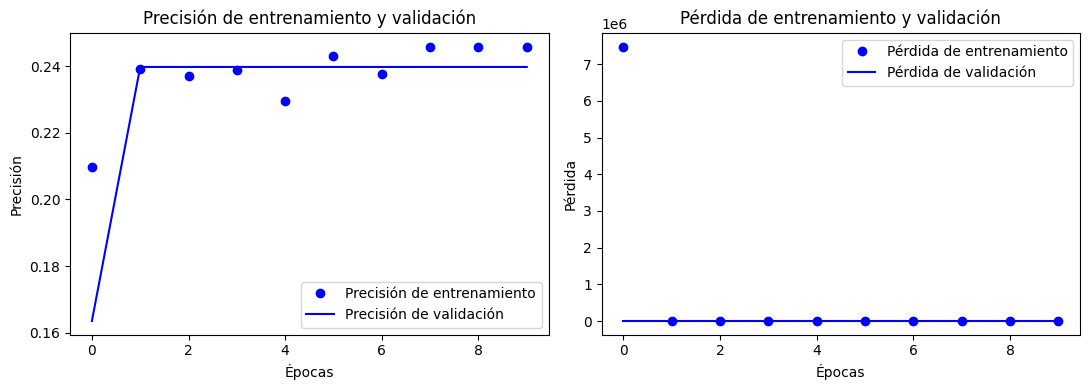

In [24]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.figure(figsize=(11, 4))

# Subplot para accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo', label='Precisión de entrenamiento')
plt.plot(epochs, val_accuracy, 'b', label='Precisión de validación')
plt.title('Precisión de entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Subplot para loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida de validación')
plt.title('Pérdida de entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## Procedimiento y Conclusiones

En este punto se replicó el modelo VGG16 para los datos particulares de este ejercicio, con la diferencia que se entrenaron todos los parámetros de la red, el resto de hiper parámetros, se dejaron iguales, para hacer una comparación justa.

Como resultado encontramos en las mis epochs la precisión no supera el 25%, lo que implica que empezamos desde un punto de partida lejano del punto anterior. En conclusión, el transfer learning es una herramienta muy poderosa ya que podemos heredar arquitecturas de redes neuronales poderosas, así como sus pesos en los que nos podemos apalancar para problemas específicos.


#### 4. _Transfer learning_ con reuso de parámetros (_fine tunning_) [30 puntos]
En la práctica es común que después de hacer _transfer learning_, los parámetros de la red, o de algunas de las últimas capas que no se habían entrenado se liberan para que sean entrenadas.

Acá, debe tomar la red que estimó en el punto 1 por _transfer learning_ y la solución la debe tomar como los valores iniciales de una nueva red, en la cual simplemente se dejan entrenables las dos últimas capas de InceptionV3 que se habían dejado no entrenables.

Compare los resultados con los modelos anteriores.

Epoch 1/10
92/92 [==============================] - 18s 122ms/step - loss: 0.0739 - accuracy: 0.9728 - val_loss: 0.5230 - val_accuracy: 0.8760
Epoch 2/10
92/92 [==============================] - 10s 98ms/step - loss: 0.0548 - accuracy: 0.9802 - val_loss: 0.8832 - val_accuracy: 0.8297
Epoch 3/10
92/92 [==============================] - 10s 110ms/step - loss: 0.0616 - accuracy: 0.9792 - val_loss: 0.8140 - val_accuracy: 0.8488
Epoch 4/10
92/92 [==============================] - 12s 128ms/step - loss: 0.0287 - accuracy: 0.9888 - val_loss: 0.6334 - val_accuracy: 0.8719
Epoch 5/10
92/92 [==============================] - 9s 94ms/step - loss: 0.0494 - accuracy: 0.9823 - val_loss: 0.8885 - val_accuracy: 0.8583
Epoch 6/10
92/92 [==============================] - 10s 94ms/step - loss: 0.0464 - accuracy: 0.9816 - val_loss: 0.7613 - val_accuracy: 0.8706
Epoch 7/10
92/92 [==============================] - 11s 118ms/step - loss: 0.0408 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.8760
Epo

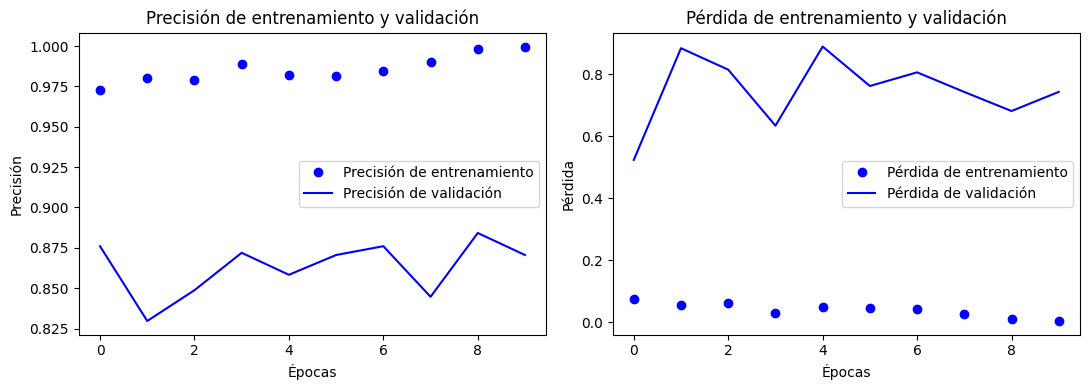

In [27]:
import matplotlib.pyplot as plt

# Copiar los pesos de la red entrenada en el punto 1
weights = model_1.get_weights()

# Crear una nueva red con las mismas capas, pero con las dos últimas capas entrenables
inception = InceptionV3(input_shape=(224,224,3),weights='imagenet', include_top=False)

# Congelar todas las capas excepto las dos últimas
for layer in inception.layers[:-2]:
    layer.trainable = False

# Agregar las capas adicionales y la capa de salida
x = GlobalAveragePooling2D()(inception.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

# Establecer los pesos de la nueva red con los pesos de la red entrenada en el punto 1
model = Model(inputs=inception.input, outputs=predictions)
model.set_weights(weights)

# Compilar el modelo
model.compile(optimizer= Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.995), loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

epochs=10

# Entrenar el modelo
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Graficar la precisión y la pérdida durante el entrenamiento
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.figure(figsize=(11, 4))

# Subplot para accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo', label='Precisión de entrenamiento')
plt.plot(epochs, val_accuracy, 'b', label='Precisión de validación')
plt.title('Precisión de entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Subplot para loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida de validación')
plt.title('Pérdida de entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


## Procedimiento y Conclusiones

En este punto se hizo el fine tunning, usando las dos redes, donde se dejó las ultimas dos capas para ser entrenadas y con los pesos de la VGG16 del primer punto.

Se observa como desde la epoch 1 se tiene una precisión del 97% en el set de Train y se tiene un valor de 87% en validación y en las otras epochs varía alrededor de este valor, obteniendo los mejores resultados de los ejercicios propuestos. Lo cual nos indica una convergencia rápida, pero con un sobre ajuste alto. En conclusión, mezclando transfer learning y fine tunning, se encuentran soluciones poderosas que apalancan las soluciones a datos particulares.